# LAB: Árboles de clasificación para la predicción de enfermedades de corazón

## 1. Introducción

En esta LAB vamos a tratar de construir un modelo para predecir la presencia de un ataque cardíaco. Para ello usaremos el dataset `Heart.csv`. Estos datos contienen un resultado binario HD para 303 pacientes que se presentaron con dolor en el pecho. 

Un valor de resultado de Sí indica la presencia de una enfermedad cardíaca basada en una prueba angiográfica, mientras que No significa ninguna enfermedad cardíaca. Hay 13 predictores incluida la edad, el sexo, el colesterol (una medida del colesterol) y otros tipos de corazón y mediciones de la función pulmonar. 

## 2. Ejercicio

### Requisitos

1. Construir un árbol de clasificaciṕon
- Construir un árbol de clasificación con scikit-learn
    - Parámetros globales
    - Importancia de los atributos
    - Visualización de árboles
    - Usar GridSearchCV para encontrar el mejor árbol

**Extra:**

- Visualizar un árbol más complejo e interpretarlo

In [1]:
# Leer los datos con Pandas.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
heart = pd.read_csv('../Data/Heart.csv')
heart.fillna('mean', inplace=True)

In [5]:
heart.isnull().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
AHD          0
dtype: int64

* Recuerden que deberán lidiar con los $NA's$ y con los atributos categoŕicos. Pueden transformarlos en dummies para pasarlos como predictores en el árbol.

In [6]:
X = heart.drop('AHD', axis=1)

In [7]:
dumm = pd.get_dummies(X[list(X.columns[X.dtypes == 'object'])],drop_first=False)

In [8]:
# Concatenamos las dummies con las cuantitativas
X = pd.concat([X[list(heart.columns[heart.dtypes != 'object'])],dumm], axis=1)
atributos = X.columns

# Transformamos el target en 0 - 1
y = pd.get_dummies(heart.AHD, drop_first=True)

In [9]:
# partimos en entrenamiento-prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
treeclf = DecisionTreeClassifier(max_depth=3, criterion='gini')
treeclf.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

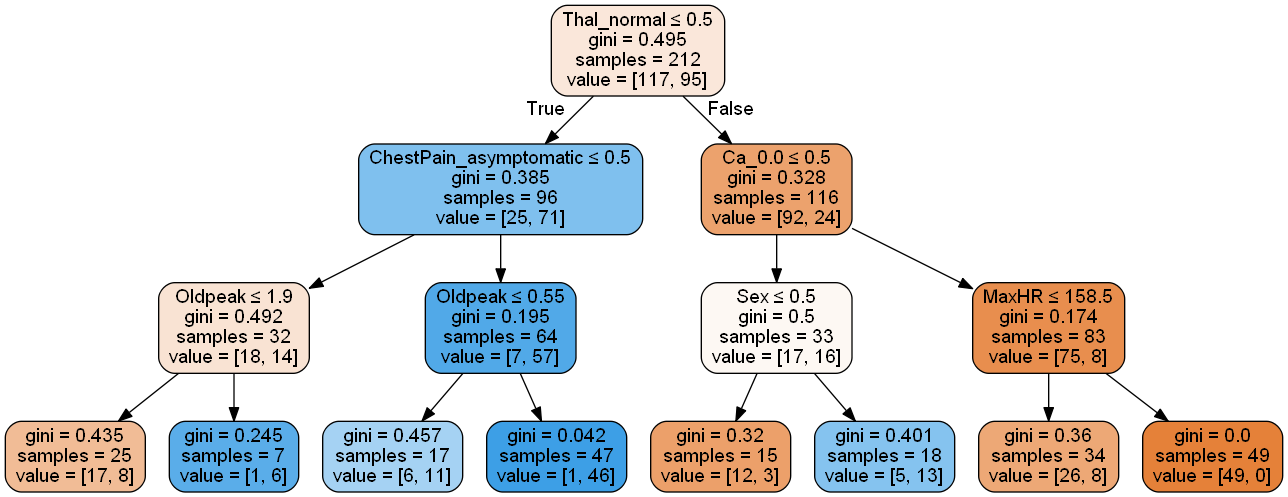

In [11]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(treeclf, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [12]:
# Calcular la importancia de los atributos
pd.DataFrame({'Atributo':atributos,
              'importancia':treeclf.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).head()

,Atributo,importancia
21,Thal_normal,0.511463
10,ChestPain_asymptomatic,0.150304
14,Ca_0.0,0.122267
8,Oldpeak,0.101267
1,Sex,0.076566


* Seguramente deben estar viendo que el árbol tiene una performance... moderarada. Tratar de tunear los hiperparámetros con GridSearch para mejorar su performance.

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=True)


PARAMETROS = {#'max_features' : [1, 5, 10, 15, 20],
              'max_depth': [1,2,3,4,5,6,7], 
              'max_leaf_nodes' : [5,10,15,20,30], 
              'min_samples_leaf' : [1,2,3,4,5,10,15,20],
              'min_samples_split' : [5,6,7,8,9,10,20]}

#Se hace la búsqueda con Grid Search
model = DecisionTreeClassifier()
gs = GridSearchCV(model, PARAMETROS, scoring='accuracy', cv=kf, verbose=1 , n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 1960 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:   14.9s finished
C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7],
     

In [14]:
gs.best_score_

0.8066037735849056

In [15]:
tree_cv = gs.best_estimator_
tree_cv.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

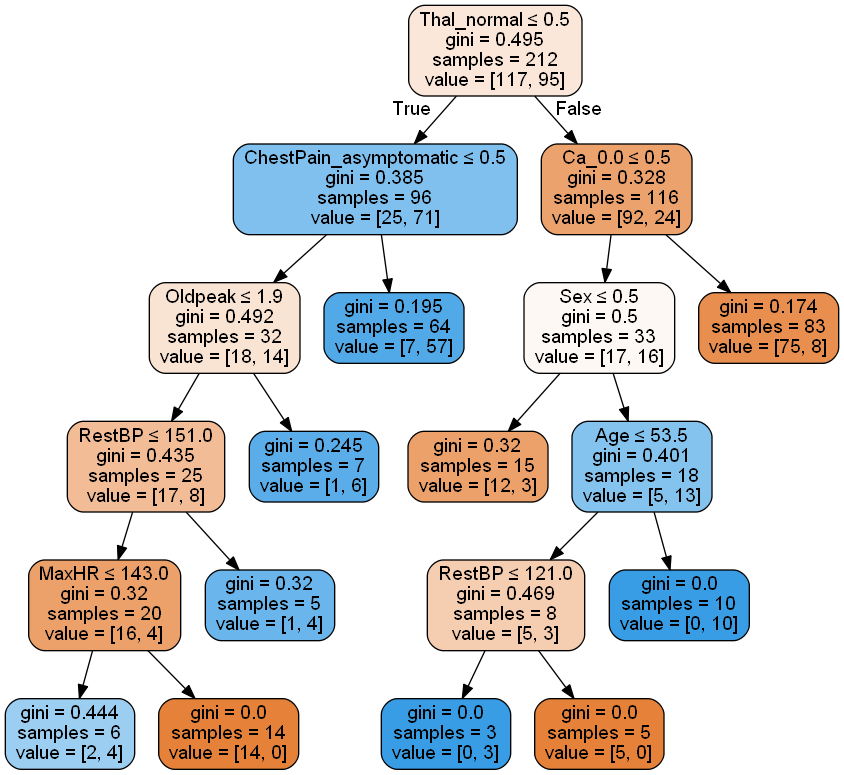

In [16]:
dot_data = export_graphviz(tree_cv, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())